# Рекомендация тарифов

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

## 1. Откроем и изучим файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
# Посмотрим на данные
display(df.head())
df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


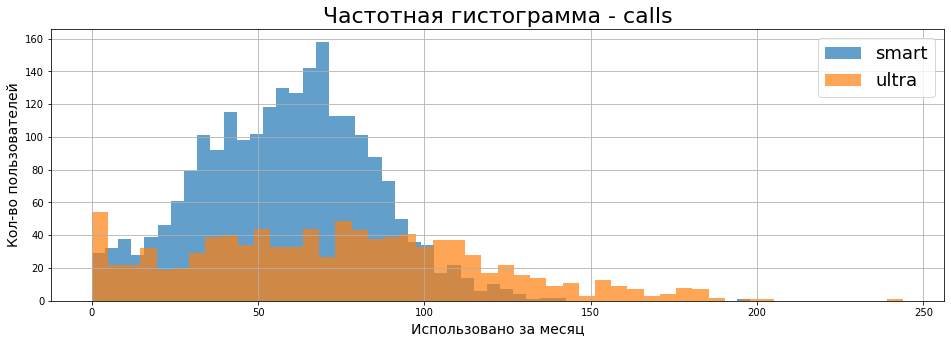

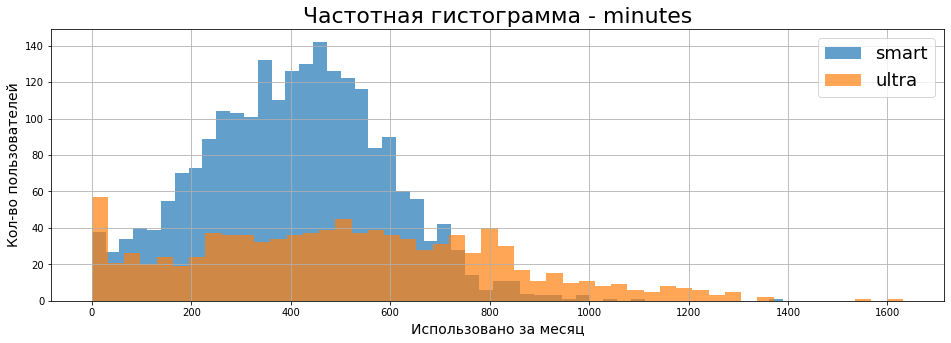

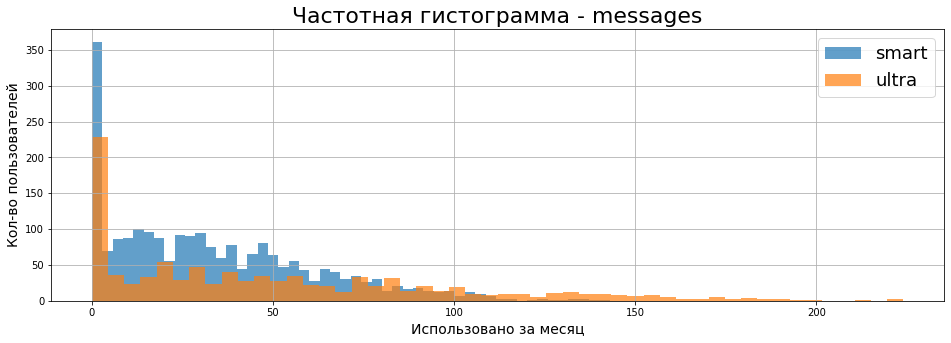

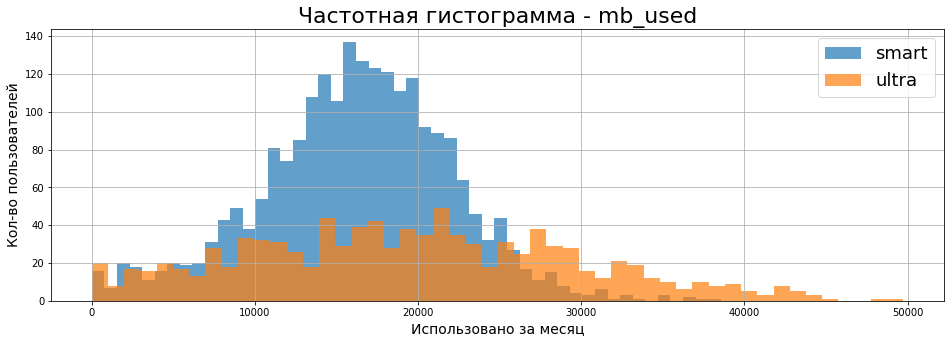

In [4]:
# Посмотрим еще раз как наши данные распределяются
for column in df.columns:
    if column != 'is_ultra':
        df[df['is_ultra'] == 0][column].hist(figsize=(16,5),
                                             alpha=0.7, bins=50, label='smart')
        df[df['is_ultra'] == 1][column].hist(figsize=(16,5),
                                             alpha=0.7, bins=50, label='ultra')
        plt.title("Частотная гистограмма - " + column, fontsize=22)
        plt.ylabel('Кол-во пользователей', fontsize=14)
        plt.xlabel('Использовано за месяц', fontsize=14)
        plt.legend(fontsize=18)
        plt.show()

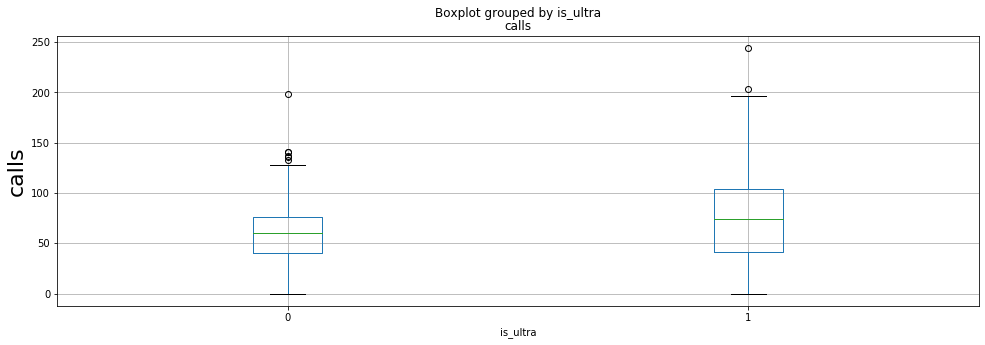

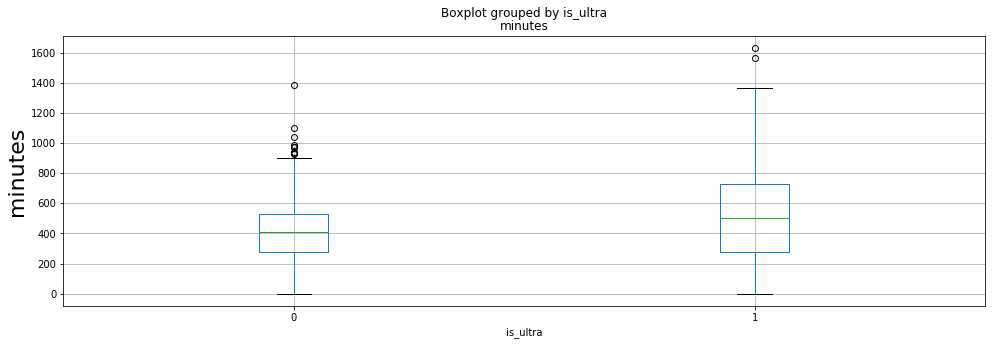

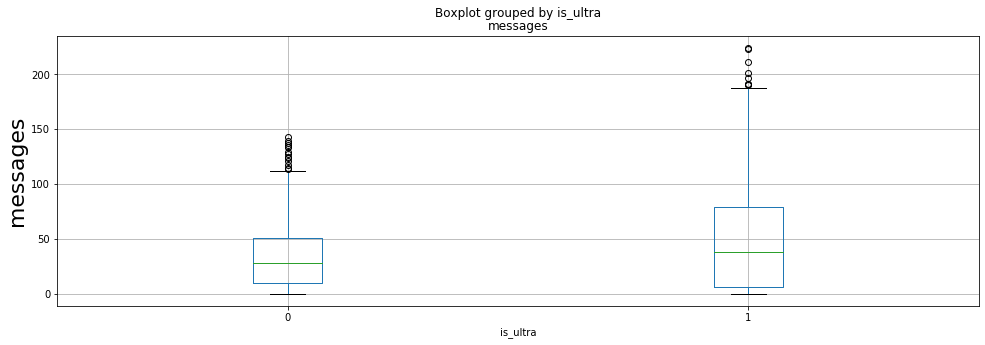

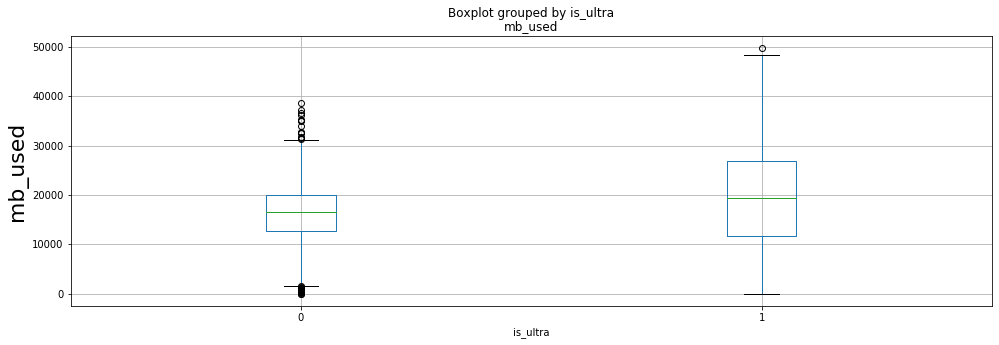

In [5]:
# Построим ящик с усами
for column in df.columns:
    if column != 'is_ultra':

        df.boxplot(column=column, by='is_ultra', figsize=(16,5))
        plt.ylabel(column, fontsize=22)
        plt.show()

In [6]:
# Посмотрим на кореляцию показателей
smart_df = df[df['is_ultra'] == 0]
ultra_df = df[df['is_ultra'] == 1]
print('Smart correlation')
display(smart_df.corr())
print('Ultra correlation')
display(ultra_df.corr())
print('Total correlation')
df.corr()

Smart correlation


,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.972654,0.208789,0.357349,NaN
minutes,0.972654,1.000000,0.203746,0.341639,NaN
messages,0.208789,0.203746,1.000000,0.146499,NaN
mb_used,0.357349,0.341639,0.146499,1.000000,NaN
is_ultra,NaN,NaN,NaN,NaN,NaN


Ultra correlation


,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.988235,0.087691,0.176856,NaN
minutes,0.988235,1.000000,0.083000,0.178003,NaN
messages,0.087691,0.083000,1.000000,0.173710,NaN
mb_used,0.176856,0.178003,0.173710,1.000000,NaN
is_ultra,NaN,NaN,NaN,NaN,NaN


Total correlation


,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


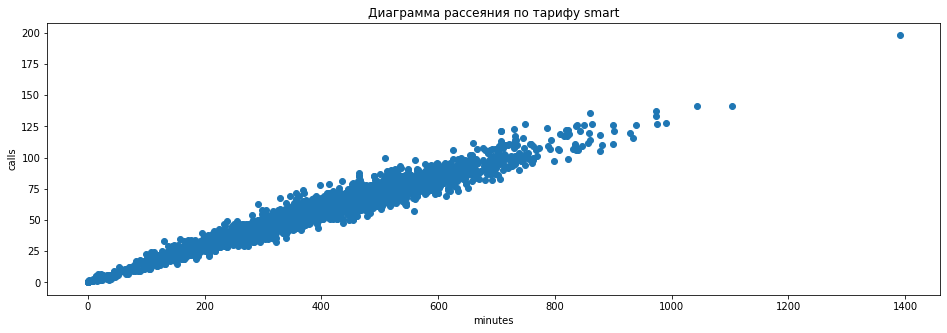

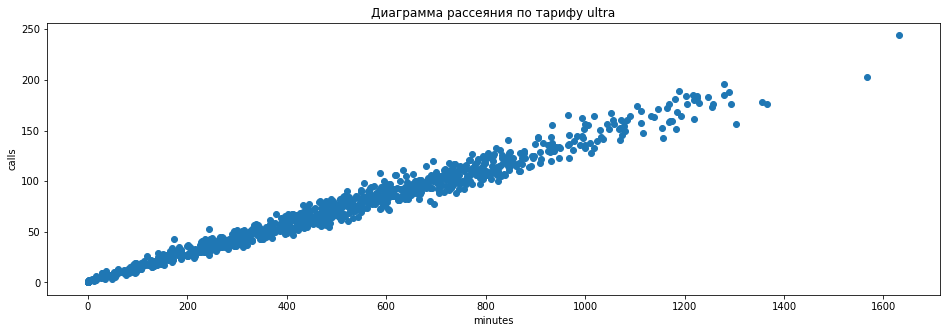

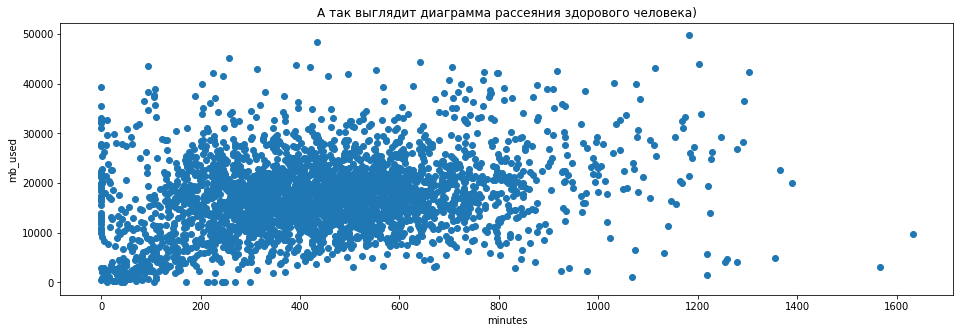

In [7]:
# Построим графики рассеивания
plt.scatter(smart_df['minutes'], smart_df['calls'])
plt.gcf().set_size_inches(16, 5)
plt.title('Диаграмма рассеяния по тарифу smart')
plt.ylabel('calls')
plt.xlabel('minutes')
plt.show()
plt.scatter(ultra_df['minutes'],ultra_df['calls'])
plt.gcf().set_size_inches(16, 5)
plt.title('Диаграмма рассеяния по тарифу ultra')
plt.ylabel('calls')
plt.xlabel('minutes')
plt.show()

# Глянем как должен выглядеть график когда кореляция не линейная
plt.scatter(df['minutes'], df['mb_used'])
plt.gcf().set_size_inches(16, 5)
plt.title('А так выглядит диаграмма рассеяния здорового человека)')
plt.ylabel('mb_used')
plt.xlabel('minutes')
plt.show()

### Вывод
Входные данные предобработаны, не содержат пропусков и готовы для дальнейшего использования. 

Здесь можно отметить пока только один важный момент, поля количество звонков и количество минут, имеют линейную зависимость, да и по сути они отражают один параметр. В дальнейшем подумаем как это стоит учесть в нашей модели.

## 2. Разобьем данные на выборки

In [8]:
# Зададим Random State для получения более предсказуемых результатов
RANDOM_STATE = 456123890
# Отберем 60% данных для обучающей выборки
train_data, tmp_data = train_test_split(df, test_size=0.4,
                                        shuffle=True, random_state=RANDOM_STATE)
# Остальные 40% поделим пополам на валидационную и тестовую выборки
validation_data, test_data = train_test_split(tmp_data, test_size=0.5,
                                              shuffle=True, random_state=RANDOM_STATE)
# Разделим все датасеты на признаки и целевую переменную
train_features = train_data.drop(columns='is_ultra')
train_targets = train_data['is_ultra']

validation_features = validation_data.drop(columns='is_ultra')
validation_targets = validation_data['is_ultra']

test_features = test_data.drop(columns='is_ultra')
test_targets = test_data['is_ultra']

# Проверим что мы нигде не ошиблись
assert len(df) == len(train_targets) + len(validation_targets) + len(test_targets)
train_data.shape

(1928, 5)

## 3. Исследуем модели

#### Логистическая регрессия

In [10]:
# Построим модель логистической регресии
logistic_regression_model = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE)
logistic_regression_model.fit(train_features, train_targets)
logistic_regression_score = logistic_regression_model.score(
    validation_features, validation_targets)
print(f'Logistic regression score = {logistic_regression_score:.2%}')

# Попробуем проверить как повлияем исключение некоторых полей
features_list = list(train_features.columns)
print('='*25, 'Checking drop the column', '='*25)
for i in range(len(features_list)):
    tmp_train_features = train_features.drop(columns=features_list[i])
    tmp_validation_features = validation_features.drop(columns=features_list[i])
    logistic_regression_model = LogisticRegression(solver='lbfgs')
    logistic_regression_model.fit(tmp_train_features, train_targets)
    logistic_regression_score = logistic_regression_model.score(
        tmp_validation_features, validation_targets)
    print(f'Droped column is {features_list[i]}')
    print(f'Logistic regression score = {logistic_regression_score:.2%}')
    
# При исключении полей звоник или сообщение результат получаем лучше чем с ними.
# А если исключить их вместе? Давайте посмотрим что получится.
print('='*25, 'Checking drop the column calls and messages together', '='*10)
tmp_train_features = train_features.drop(columns=['calls', 'messages'])
tmp_validation_features = validation_features.drop(columns=['calls', 'messages'])
logistic_regression_model = LogisticRegression(solver='lbfgs')
logistic_regression_model.fit(tmp_train_features, train_targets)
logistic_regression_score = logistic_regression_model.score(
    tmp_validation_features, validation_targets)
print(f'Logistic regression score = {logistic_regression_score:.2%}')

Logistic regression score = 71.70%
========================= Checking drop the column =========================
Droped column is calls
Logistic regression score = 75.58%
Droped column is minutes
Logistic regression score = 75.74%
Droped column is messages
Logistic regression score = 74.49%
Droped column is mb_used
Logistic regression score = 75.12%
========================= Checking drop the column calls and messages together ==========
Logistic regression score = 74.34%


### Вывод
Наибольшую точность в модели логисической регрессии мы получили 75% при исключении полей со звонками или с сообщеиниями.

Что самое интересное, при одновременном удалении этих полей результат сохраняется на уровне 75%.
Похоже наше предположение о том что некоторые поля не несут для нас ценность начинает подтверждаться.

#### Решающее дерево

In [11]:
# Создадим дерево принятия решений и проверим разные гиперпараметры
# Проверим как влияет максимальная глубина дерева
for i in range(1, 10, 2):
    tree_model = DecisionTreeClassifier(max_depth=i, random_state=RANDOM_STATE)
    tree_model.fit(train_features, train_targets)
    score = tree_model.score(validation_features, validation_targets)
    print(f'tree_model score for max_depth = {i} is {score}')

# Остановимся на варианте глубины дерева 3
# Попробуем проверить как повлияем исключение некоторых полей
features_list = list(train_features.columns)
print('='*25, 'Checking drop the column', '='*25)
for column in features_list:
    tmp_train_features = train_features.drop(columns=column)
    tmp_validation_features = validation_features.drop(columns=column)
    tree_model = DecisionTreeClassifier(max_depth=3)
    tree_model.fit(tmp_train_features, train_targets)
    score = tree_model.score(tmp_validation_features, validation_targets)
    print(f'Droped column is {column}')
    print(f'tree_model score is {score}')

tree_model score for max_depth = 1 is 0.7620528771384136
tree_model score for max_depth = 3 is 0.7947122861586314
tree_model score for max_depth = 5 is 0.7931570762052877
tree_model score for max_depth = 7 is 0.7822706065318819
tree_model score for max_depth = 9 is 0.7884914463452566
========================= Checking drop the column =========================
Droped column is calls
tree_model score is 0.7947122861586314
Droped column is minutes
tree_model score is 0.7947122861586314
Droped column is messages
tree_model score is 0.7931570762052877
Droped column is mb_used
tree_model score is 0.7853810264385692


### Вывод
Дерево нам дает результат лучше чем логистическая регрессия - 79% при глубине дерева 3.

Удаление полей calls или minutes результат сохраняет на уровне 79%, что говорит нам о том что одно из этих полей можно не брать.

#### Случайный лес

In [12]:
# Выберем лучшую комбинация уровня дерева и количества деревьев
for estimator in range(1, 100, 20):
    for depth in range(1, 6):
        random_forest_model = RandomForestClassifier(
            n_estimators=estimator, max_depth=depth, random_state=RANDOM_STATE)
        random_forest_model.fit(train_features, train_targets)
        score = random_forest_model.score(validation_features, validation_targets)
        print(f'n_estimators={estimator:<2}, max_depth={depth}, score= {score}')
        
# Остановимся на 21 дереве с глубиной 3
# Провперим как влияет удаление полей
features_list = list(train_features.columns)
print('='*25, 'Checking drop the column', '='*25)
for column in features_list:
    tmp_train_features = train_features.drop(columns=column)
    tmp_validation_features = validation_features.drop(columns=column)
    
    random_forest_model = RandomForestClassifier(
            n_estimators=21, max_depth=4)
    random_forest_model.fit(tmp_train_features, train_targets)
    score = random_forest_model.score(tmp_validation_features, validation_targets)
    
    print(f'Droped column is {column}')
    print(f'random_forest_model score is {score}')

n_estimators=1 , max_depth=1, score= 0.7589424572317263
n_estimators=1 , max_depth=2, score= 0.7978227060653188
n_estimators=1 , max_depth=3, score= 0.8055987558320373
n_estimators=1 , max_depth=4, score= 0.8195956454121306
n_estimators=1 , max_depth=5, score= 0.8164852255054432
n_estimators=21, max_depth=1, score= 0.7853810264385692
n_estimators=21, max_depth=2, score= 0.7838258164852255
n_estimators=21, max_depth=3, score= 0.8009331259720062
n_estimators=21, max_depth=4, score= 0.8118195956454122
n_estimators=21, max_depth=5, score= 0.8087091757387247
n_estimators=41, max_depth=1, score= 0.7869362363919129
n_estimators=41, max_depth=2, score= 0.7869362363919129
n_estimators=41, max_depth=3, score= 0.80248833592535
n_estimators=41, max_depth=4, score= 0.8102643856920684
n_estimators=41, max_depth=5, score= 0.8102643856920684
n_estimators=61, max_depth=1, score= 0.7916018662519441
n_estimators=61, max_depth=2, score= 0.7900466562986003
n_estimators=61, max_depth=3, score= 0.80404354587

### Вывод
Случайный лес дал нам самую большую точность на валидационных данных - 80% и подтвердил что поле minutes можно удалить, если результат то же зачем нам дополнительная вычислительная нагрузка?

In [13]:
# Сохраним наши лучшие модели и протестируем их на тестовых данных
new_train_features = train_features.drop(columns='minutes')
new_validation_features = validation_features.drop(columns='minutes')

# Попробуем дообучить нашу модель присоеденив к тренировочному датасету валидационный
new_train_features = pd.concat([new_train_features, new_validation_features])
train_targets = pd.concat([train_targets, validation_targets])

# Логистическая регрессия
# При удалении минут а не звонков лог.регрессия ведет себя хуже, но в целом
# лог.регресиия у нас отстает по точности, поэтому мы ей пожертвуем ради стандартизации
logistic_regression_model = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE)
logistic_regression_model.fit(new_train_features, train_targets)
logistic_regression_score = logistic_regression_model.score(
    new_validation_features, validation_targets)
joblib.dump(logistic_regression_model, 'logistic_regression_model.joblib')
print(f'logistic_regression_score = {logistic_regression_score:.2%}')

# Дерево решений
tree_model = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
tree_model.fit(new_train_features, train_targets)
tree_score = tree_model.score(new_validation_features, validation_targets)
joblib.dump(tree_model, 'tree_model.joblib')
print(f'tree_score = {tree_score:.2%}')

# Случайный лес
random_forest_model = RandomForestClassifier(
            n_estimators=41, max_depth=4, random_state=RANDOM_STATE)
random_forest_model.fit(new_train_features, train_targets)
random_forest_score = random_forest_model.score(new_validation_features, validation_targets)
joblib.dump(random_forest_model, 'random_forest_model.joblib')
print(f'random_forest_score = {random_forest_score:.2%}')

logistic_regression_score = 72.01%
tree_score = 81.03%
random_forest_score = 81.49%


### Вывод
На валидационных данных, случайный лес показывает лучший результат. 
Пришло время проверить работу моделей на тестовых данных!

## 4. Проверим модель на тестовой выборке

In [14]:
# Удалим поле минуты из тестового датасета
new_test_features = test_features.drop(columns='minutes')

# Логистическая регрессия
logistic_regression_model = joblib.load('logistic_regression_model.joblib')
logistic_regression_score = logistic_regression_model.score(new_test_features, test_targets)
print(f'logistic_regression_score = {logistic_regression_score}')

# Дерево решений
tree_model = joblib.load('tree_model.joblib')
tree_score = tree_model.score(new_test_features, test_targets)
print(f'tree_score = {tree_score}')

# Случайный лес
random_forest_model = joblib.load('random_forest_model.joblib')
random_forest_score = random_forest_model.score(new_test_features, test_targets)
print(f'random_forest_score = {random_forest_score}')

logistic_regression_score = 0.7107309486780715
tree_score = 0.7884914463452566
random_forest_score = 0.7993779160186625


### Вывод
На тестовый данных лучший результат показал случайный лес, хоть и с небольшим отрывом от дерева решений.


## 5. Проверим модели на адекватность

In [15]:
# Посмотрим как нам выбрать данные для тестов
print('Ultra')
display(df[df['is_ultra'] == 1].describe())
print('Smart')
display(df[df['is_ultra'] == 0].describe())

Ultra


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


Smart


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


In [16]:
# Создадим несколько тестовых кейсов

# Проверим что наша модель посоветует пользователю который почти не использует услуги.
# Заполним самые минимальные параметры до первого квантиля тарифа смарт
columns = list(new_test_features.columns)
data = {'calls': [0, 1, 40],
        'messages':[0, 1, 10],
        'mb_used':[0, 1, 12643.05]   
}

passive_user = pd.DataFrame(data, columns=columns)
result = random_forest_model.predict(passive_user)
print(f'Рекомендации пользователю который почти не пользуется услугами', result)

# Проверим что наша модель посоветует активному пользователю.
data = {'calls': [104, 244, 500],
        'messages':[79, 224, 500],
        'mb_used':[26837.72, 49745.73, 100000]   
}

active_user = pd.DataFrame(data, columns=columns)
result = random_forest_model.predict(active_user)
print(f'Рекомендации активному пользователю', result)

Рекомендации пользователю который почти не пользуется услугами [0 0 0]
Рекомендации активному пользователю [1 1 1]


In [17]:
# Посмотрим на пограничные случаи и составит датасет из медиан каждого тарифа
# Первый идет Ultra, второй - Smart
data = {'calls': [74, 60],
        'messages':[38, 28],
        'mb_used':[19308.01, 16506.93]   
}

active_user = pd.DataFrame(data, columns=columns)
result = random_forest_model.predict(active_user)
print(f'Рекомендация медианным значениям тарифам Ultra и Smart соотвественно:', result)

Рекомендация медианным значениям тарифам Ultra и Smart соотвественно: [0 0]


### Вывод

Работа модели на крайних случаях выглядит не плохо, она советует тариф Ultra для тех кто активно пользуется услугами и тариф Smart для тех кто не так активен.

С медианными значениями все сложнее и это можно понять. Данные тарифа Ultra распределение более менее равномерно, в то время как данные тарифа Smart распределены близко к нормальному распределению с мат ожиданием близким к  медианным значениям обоих тарифов, отсюда и доминирование тарифа Smart в рекомендациях на близких к медианным значениям.

В целом рекомендадельная модель дает точность близку к целевой, а значит задачу можем считать выполненной.

#### Посмотрим на сколько целесообразно бизнесу внедрять данную модель

In [18]:
# Предположим что мы будем всем рекомендовать тариф Смарт
acuracy = df[df['is_ultra']==0]['is_ultra'].count() / df.shape[0]
print(f'Точность рекомендаций без использования модели будет {acuracy:.2%}')

# Давайте проверим какую точность предсказаний покажет наша модель
features_df = df.drop(columns=['is_ultra', 'minutes'])
target_df = df['is_ultra']

random_forest_model = joblib.load('random_forest_model.joblib')
random_forest_score = random_forest_model.score(features_df, target_df)
print(f'Точность рекомендаций c использованием случайного леса {random_forest_score:.2%}')

Точность рекомендаций без использования модели будет 69.35%
Точность рекомендаций c использованием случайного леса 80.12%


### Вывод

Если использовать модель мы получаем точность предсказаний почти на 11% выше. Т.е. каждый десятый клиент может не перейти на новый тариф если мы не будем использовать для рекомендаций нашу модель.

----